In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
from scipy import stats
import math
from sklearn.linear_model import LinearRegression

In [9]:
taxi = pd.read_csv('taxi_data.csv')
taxi = taxi.drop('Unnamed: 0', axis=1)
taxi.weather_summary.unique()

array(['Overcast', 'Mostly Cloudy', 'Clear', 'Partly Cloudy',
       'Light Rain', 'Rain', 'Heavy Rain', nan, 'Humid and Overcast'],
      dtype=object)

In [12]:
# dropping all columns with any NaNs
taxi = taxi.dropna()
taxi.info()
taxi.weather_summary.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245054 entries, 0 to 249720
Data columns (total 16 columns):
tpep_pickup_datetime     245054 non-null object
tpep_dropoff_datetime    245054 non-null object
passenger_count          245054 non-null int64
trip_distance            245054 non-null float64
RatecodeID               245054 non-null int64
PULocationID             245054 non-null int64
DOLocationID             245054 non-null int64
payment_type             245054 non-null int64
fare_amount              245054 non-null float64
tip_amount               245054 non-null float64
tolls_amount             245054 non-null float64
total_amount             245054 non-null float64
trip_time                245054 non-null object
rounded_DOtime           245054 non-null object
apparentTemperature      245054 non-null float64
weather_summary          245054 non-null object
dtypes: float64(6), int64(5), object(5)
memory usage: 31.8+ MB


array(['Overcast', 'Mostly Cloudy', 'Clear', 'Partly Cloudy',
       'Light Rain', 'Rain', 'Heavy Rain', 'Humid and Overcast'],
      dtype=object)

In [45]:
# resampling as 250k records was still too much to work with
taxi.head()
taxi_test = taxi.sample(50000).reset_index(drop=True)
taxi_test.shape

(50000, 16)

In [46]:
# renaming columns to simpler ones
taxi_test = taxi_test.rename(columns={'tpep_pickup_datetime':'pickup_dt', 'tpep_dropoff_datetime':'dropoff_dt'})
taxi_test = taxi_test.drop('rounded_DOtime', axis=1)
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,trip_time,apparentTemperature,weather_summary
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,0.00,10.30,0 days 00:12:22.000000000,40.91,Clear
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,0.00,20.16,0 days 00:19:34.000000000,63.37,Mostly Cloudy
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,0.00,14.30,0 days 00:18:13.000000000,59.20,Overcast
3,2018-10-25 16:10:09,2018-10-25 16:18:11,0,0.90,1,264,264,1,7.0,1.00,0.00,9.80,0 days 00:08:02.000000000,51.01,Clear
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,5.76,75.67,0 days 00:54:32.000000000,74.28,Mostly Cloudy


In [47]:
taxi_test.pickup_dt = [pd.to_datetime(x) for x in taxi_test.pickup_dt]
taxi_test.dropoff_dt = [pd.to_datetime(x) for x in taxi_test.dropoff_dt]

In [29]:
taxi_test.trip_time[0]

'00:06:03.000000000'

In [48]:
# stripping to be able to convert to datetime.time
taxi_test.trip_time = taxi_test.trip_time.str.replace('0 days ', '')

In [50]:
taxi_test.trip_time = [pd.to_datetime(x) for x in taxi_test.trip_time]
taxi_test.trip_time = [val.time() for val in taxi_test.trip_time]


In [36]:
type(taxi_test.trip_time[0])

datetime.time

In [25]:
taxi_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
pickup_dt              50000 non-null datetime64[ns]
dropoff_dt             50000 non-null datetime64[ns]
passenger_count        50000 non-null int64
trip_distance          50000 non-null float64
RatecodeID             50000 non-null int64
PULocationID           50000 non-null int64
DOLocationID           50000 non-null int64
payment_type           50000 non-null int64
fare_amount            50000 non-null float64
tip_amount             50000 non-null float64
tolls_amount           50000 non-null float64
total_amount           50000 non-null float64
trip_time              50000 non-null object
apparentTemperature    50000 non-null float64
weather_summary        50000 non-null object
dtypes: datetime64[ns](2), float64(6), int64(5), object(2)
memory usage: 5.7+ MB


In [51]:
# calculating weekdays
import datetime
taxi_test.dropoff_dt[0].weekday()
taxi_test['day_of_week'] = [x.weekday() for x in taxi_test.dropoff_dt]
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,trip_time,apparentTemperature,weather_summary,day_of_week
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,0.00,10.30,00:12:22,40.91,Clear,3
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,0.00,20.16,00:19:34,63.37,Mostly Cloudy,4
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,0.00,14.30,00:18:13,59.20,Overcast,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,0,0.90,1,264,264,1,7.0,1.00,0.00,9.80,00:08:02,51.01,Clear,3
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,5.76,75.67,00:54:32,74.28,Mostly Cloudy,2


In [65]:
# testing converting time to seconds
from datetime import timedelta
(taxi_test.dropoff_dt[0] - taxi_test.pickup_dt[0]).total_seconds()

742.0

In [67]:
# converting time to minutes as an integer
taxi_test.trip_time = [(taxi_test.dropoff_dt[i] - taxi_test.pickup_dt[i]).total_seconds()/60 for i in range(len(taxi_test))]
taxi_test.head()
taxi_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
pickup_dt              50000 non-null datetime64[ns]
dropoff_dt             50000 non-null datetime64[ns]
passenger_count        50000 non-null int64
trip_distance          50000 non-null float64
RatecodeID             50000 non-null int64
PULocationID           50000 non-null int64
DOLocationID           50000 non-null int64
payment_type           50000 non-null int64
fare_amount            50000 non-null float64
tip_amount             50000 non-null float64
tolls_amount           50000 non-null float64
total_amount           50000 non-null float64
trip_time              50000 non-null float64
apparentTemperature    50000 non-null float64
weather_summary        50000 non-null object
day_of_week            50000 non-null int64
dtypes: datetime64[ns](2), float64(7), int64(6), object(1)
memory usage: 6.1+ MB


In [82]:
# testing time of day segmenting before running it in separate notebook
taxi_test.dropoff_dt[0].time() > datetime.time(10,0,0)
taxi_test['time_of_day'] = ''
taxi_test.head()
taxi_test.to_csv('taxi_test.csv')

In [8]:
# creating dummies
taxi_test = pd.read_csv('taxi_test.csv')
weather_dummies = pd.get_dummies(taxi_test.weather_summary, prefix='weather_summary')
taxi_test = pd.concat([taxi_test, weather_dummies], axis=1)
taxi_test.head()

,Unnamed: 0,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,day_of_week,time_of_day,weather_summary_Clear,weather_summary_Heavy Rain,weather_summary_Humid and Overcast,weather_summary_Light Rain,weather_summary_Mostly Cloudy,weather_summary_Overcast,weather_summary_Partly Cloudy,weather_summary_Rain
0,0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,...,3,NaN,1,0,0,0,0,0,0,0
1,1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,...,4,NaN,0,0,0,0,1,0,0,0
2,2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,...,0,NaN,0,0,0,0,0,1,0,0
3,3,2018-10-25 16:10:09,2018-10-25 16:18:11,0,0.90,1,264,264,1,7.0,...,3,NaN,1,0,0,0,0,0,0,0
4,4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,...,2,NaN,0,0,0,0,1,0,0,0


In [84]:
# creating separate dataframe removing 0 passengers. ultimately did not use this 
taxi_test1 = taxi_test[taxi_test.passenger_count!=0]

In [10]:
# replacing 0 passengers with 1
taxi_test.passenger_count = taxi_test.passenger_count.replace(0,1)

In [11]:
taxi_test[taxi_test.passenger_count == 0]

,Unnamed: 0,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,day_of_week,time_of_day,weather_summary_Clear,weather_summary_Heavy Rain,weather_summary_Humid and Overcast,weather_summary_Light Rain,weather_summary_Mostly Cloudy,weather_summary_Overcast,weather_summary_Partly Cloudy,weather_summary_Rain


In [12]:
# passenger dummies
passenger_dummies = pd.get_dummies(taxi_test.passenger_count, prefix='passenger_count')
taxi_test = pd.concat([taxi_test, passenger_dummies], axis=1)
taxi_test.head()

,Unnamed: 0,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,weather_summary_Mostly Cloudy,weather_summary_Overcast,weather_summary_Partly Cloudy,weather_summary_Rain,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6
0,0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,...,0,0,0,0,1,0,0,0,0,0
1,1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,...,1,0,0,0,1,0,0,0,0,0
2,2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,...,0,1,0,0,1,0,0,0,0,0
3,3,2018-10-25 16:10:09,2018-10-25 16:18:11,1,0.90,1,264,264,1,7.0,...,0,0,0,0,1,0,0,0,0,0
4,4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,...,1,0,0,0,1,0,0,0,0,0


In [13]:
# rate code dummies
rate_code_dummies = pd.get_dummies(taxi_test.RatecodeID, prefix='RatecodeID')
taxi_test = pd.concat([taxi_test, rate_code_dummies], axis=1)
taxi_test.head()

,Unnamed: 0,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_99
0,0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,...,0,0,0,0,1,0,0,0,0,0
1,1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,...,0,0,0,0,1,0,0,0,0,0
2,2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,...,0,0,0,0,1,0,0,0,0,0
3,3,2018-10-25 16:10:09,2018-10-25 16:18:11,1,0.90,1,264,264,1,7.0,...,0,0,0,0,1,0,0,0,0,0
4,4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
# removing trips where distance was 0
taxi_test[taxi_test.trip_distance == 0.00]
taxi_test = taxi_test[taxi_test.trip_distance != 0.00]

In [15]:
taxi_test = taxi_test[taxi_test.RatecodeID != 99]
taxi_test.drop('RatecodeID_99', axis=1, inplace=True)

In [16]:
taxi_test.reset_index(drop=True)
taxi_test.shape

(49642, 37)

In [109]:
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,...,0,0,0,0,0,1,0,0,0,0
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,...,0,0,0,0,0,1,0,0,0,0
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,...,0,0,0,0,0,1,0,0,0,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,1,0.90,1,264,264,1,7.0,1.00,...,0,0,0,0,0,1,0,0,0,0
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,...,0,0,0,0,0,0,1,0,0,0


In [17]:
# payment type dummies
payment_dummies = pd.get_dummies(taxi_test.payment_type, prefix='payment_type')
taxi_test = pd.concat([taxi_test, payment_dummies], axis=1)

In [18]:
# day of the week dummies
day_of_week_dummies = pd.get_dummies(taxi_test.day_of_week, prefix='day_of_week')
taxi_test = pd.concat([taxi_test, day_of_week_dummies], axis=1)

In [19]:
taxi_test.columns

Index(['Unnamed: 0', 'pickup_dt', 'dropoff_dt', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_time', 'apparentTemperature', 'weather_summary',
       'day_of_week', 'time_of_day', 'weather_summary_Clear',
       'weather_summary_Heavy Rain', 'weather_summary_Humid and Overcast',
       'weather_summary_Light Rain', 'weather_summary_Mostly Cloudy',
       'weather_summary_Overcast', 'weather_summary_Partly Cloudy',
       'weather_summary_Rain', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'RatecodeID_1', 'RatecodeID_2', 'RatecodeID_3',
       'RatecodeID_4', 'RatecodeID_5', 'payment_type_1', 'payment_type_2',
       'payment_type_3', 'payment_type_4', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_

In [40]:
taxi_testm = taxi_test.drop(['Unnamed: 0','passenger_count',
                             'payment_type', 'weather_summary', 'day_of_week'], axis=1)

In [41]:
taxi_testm.head()

,pickup_dt,dropoff_dt,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,tolls_amount,total_amount,...,payment_type_2,payment_type_3,payment_type_4,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1.70,1,262,229,9.5,0.00,0.00,10.30,...,1,0,0,0,0,0,1,0,0,0
1,2018-10-05 20:17:42,2018-10-05 20:37:16,3.23,1,249,87,15.5,3.36,0.00,20.16,...,0,0,0,0,0,0,0,1,0,0
2,2018-10-15 09:24:44,2018-10-15 09:42:57,2.66,1,100,236,13.5,0.00,0.00,14.30,...,1,0,0,1,0,0,0,0,0,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,0.90,1,264,264,7.0,1.00,0.00,9.80,...,0,0,0,0,0,0,1,0,0,0
4,2018-10-10 18:56:38,2018-10-10 19:51:10,18.37,2,132,48,52.0,12.61,5.76,75.67,...,0,0,0,0,0,1,0,0,0,0


In [42]:
taxi_testm = taxi_testm.drop('total_amount', axis=1)

In [44]:
# looking at correlatins specifically for tip amount. found that faare and distance were multicolinear
taxi_testm.corr()['tip_amount']

trip_distance                         0.565635
RatecodeID                            0.291889
PULocationID                         -0.038515
DOLocationID                         -0.039681
fare_amount                           0.596066
tip_amount                            1.000000
tolls_amount                          0.470548
trip_time                             0.090498
apparentTemperature                   0.011323
time_of_day                                NaN
weather_summary_Clear                 0.016652
weather_summary_Heavy Rain            0.000700
weather_summary_Humid and Overcast   -0.002847
weather_summary_Light Rain           -0.009950
weather_summary_Mostly Cloudy        -0.002162
weather_summary_Overcast             -0.017926
weather_summary_Partly Cloudy         0.008760
weather_summary_Rain                 -0.005015
passenger_count_1                     0.004642
passenger_count_2                    -0.000325
passenger_count_3                    -0.004007
passenger_cou

In [145]:
taxi_testm.drop('trip_distance', axis=1, inplace=True)

In [43]:
taxi_testm.to_csv('taxi_testm.csv')

In [25]:
# first model!
f='tip_amount~fare_amount+tolls_amount+RatecodeID_1+RatecodeID_2+RatecodeID_3+RatecodeID_4+payment_type_1+payment_type_2+trip_time'
taxi_model = ols(f, taxi_testm).fit()
taxi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     7926.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:02:39   Log-Likelihood:                -93932.
No. Observations:               49642   AIC:                         1.879e+05
Df Residuals:                   49632   BIC:                         1.880e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.0157      0.179    -28.035      0.000      -5.366      -4.665
fare_amount        0.1087      0.001    116.058      0.000       0.107       0.110
tolls_amount       0.2386      0.007     36.514      0.000       0.226       0.251
RatecodeID_1       3.2328      0.144     22.523      0.000       2.951       3.514
RatecodeID_2       3.4556      0.147     23.579      0.000       3.168       3.743
RatecodeID_3       3.0526      0.234     13.059      0.000       2.594       3.511
RatecodeID_4       4.1765      0.285     14.656      0.000       3.618       4.735
payment_type_1     2.9215      0.103     28.373      0.000       2.720       3.123
payment_type_2     0.3602      0.103      3.481      0.001       0.157       0.563
trip_time         -0.0004      0.000     -3.700      0.000      -0.001      -0.000
==============================================================================
Omnibus:                    39620.116   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25566043.199
Skew:                           2.661   Prob(JB):                         0.00
Kurtosis:                     114.049   Cond. No.                     3.37e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
taxi_testm[taxi_testm.tip_amount == 0].shape
taxi_testm.payment_type_1.value_counts()

1    35132
0    14510
Name: payment_type_1, dtype: int64

In [46]:
taxi_testm.drop('time_of_day', axis=1, inplace=True)

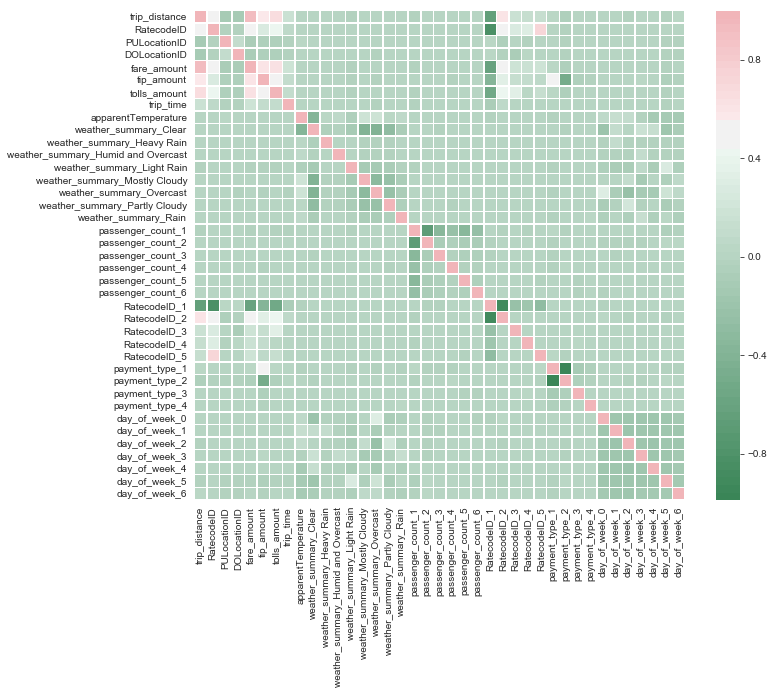

In [47]:
# correlation heat map
corr = taxi_testm.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 10, n=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, center=.5,
             linewidths=.5)
sns.set_style('darkgrid')

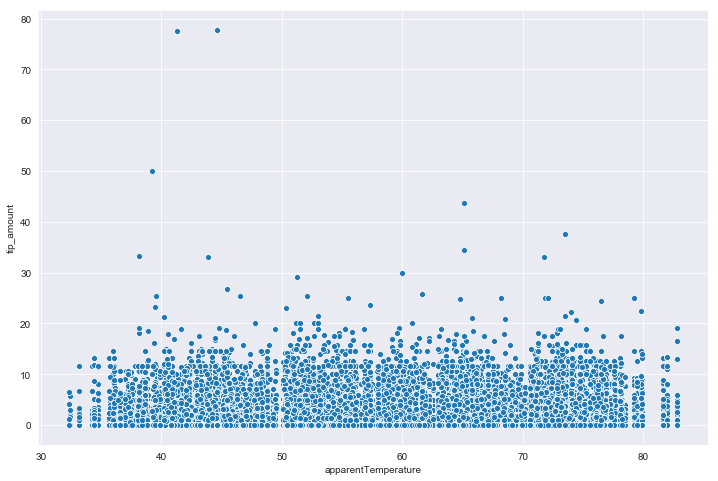

In [56]:
# zero correlation chart used for presentation
fig = plt.figure(figsize=(12,8))
sns.scatterplot(taxi_testm.apparentTemperature, taxi_testm.tip_amount)

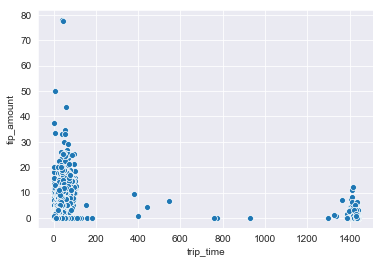

In [49]:
sns.scatterplot(taxi_testm.trip_time, taxi_testm.tip_amount)